## Prepare imports

In [3]:
import torch
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from models.ectencoder_mnist import BaseModel as EctEncoder
from datasets.mnist import MnistDataModule, MnistDataModuleConfig
from layers.ect import EctLayer, EctConfig
from directions import generate_2d_directions

DEVICE = "cuda:0"
config = OmegaConf.load("./configs/config_encoder_mnist.yaml")

## Load Models and Data

In [4]:
layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_2d_directions(config.layer.ect_size, DEVICE),
)

dm = MnistDataModule(MnistDataModuleConfig(root="./data/mnistpointcloud"))

# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/{config.model.save_name}",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.model.hidden_size,
    num_pts=config.model.num_pts,
    num_dims=config.model.num_dims,
    learning_rate=config.model.learning_rate,
).to(DEVICE)


## Generate an ECT and use VAE as autoencoder to recreate the ECT

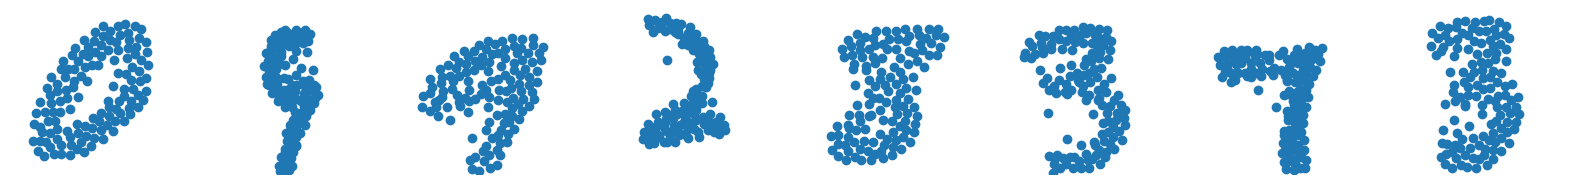

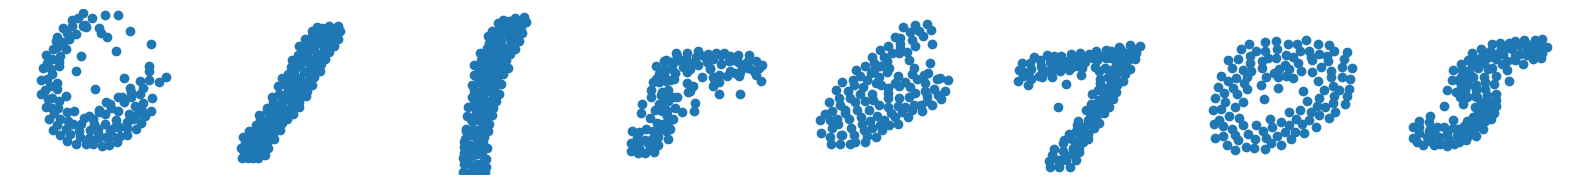

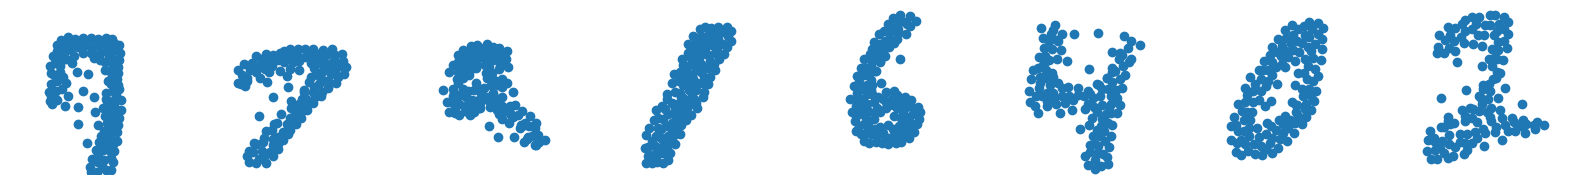

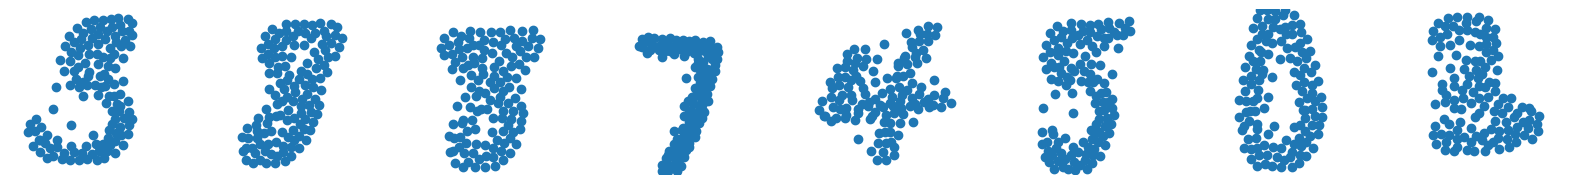

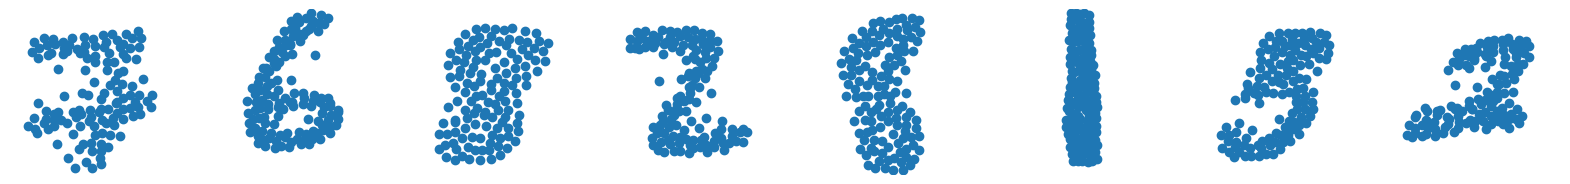

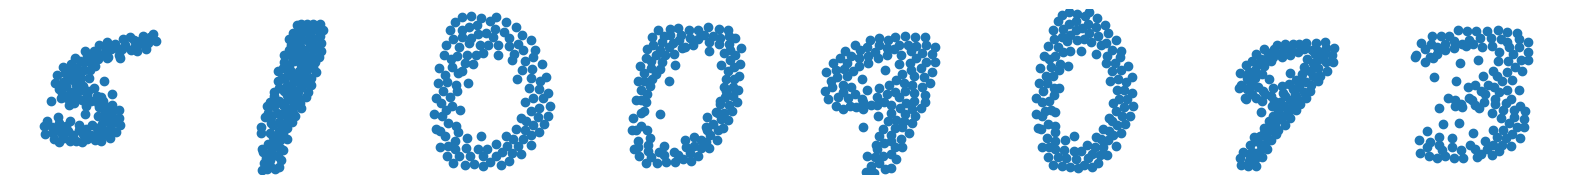

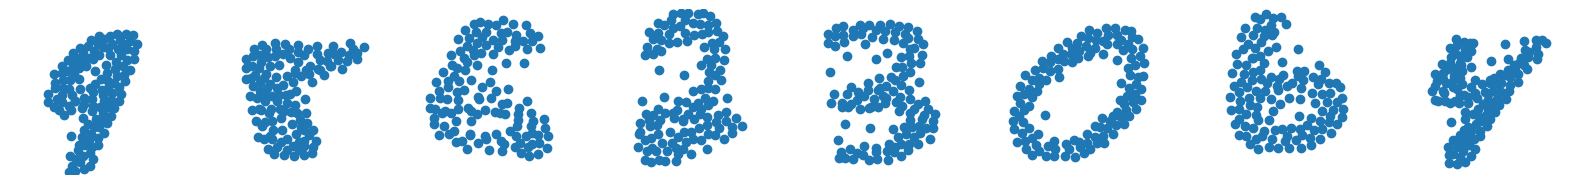

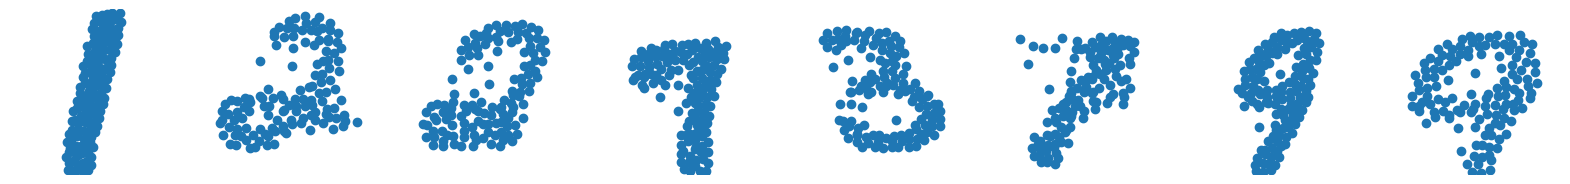

In [5]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)




# Pass reconstruction through the point cloud decoder


def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect)


n_images = 8

for idx in range(0,64,8):
    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
    )


    for recon_pts,ax in zip(recon_batch[idx::],axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        recon_pts = rotate(recon_pts, degrees=-90)


        ax.scatter(recon_pts[:,0],recon_pts[:,1])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_aspect(1)
        ax.axis("off")
